# Taming Fluctuations - 224x224 

### Findings
- xx

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import collections

In [3]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate
import os
import pickle

import scipy
from scipy.stats import gmean, hmean

In [4]:
import fastai_addons   #add plot2 extension -- learn.recorder.plot2()
from fastai_addons import interpretation_summary, plot_confusion_matrix, \
                          get_accuracy, analyze_confidence, accuracy_vs_threshold, \
                          show_incremental_accuracy,  analyze_low_confidence, \
                          plot_confusion_matrix_thresh, get_val_stats, model_cutter

In [5]:
#from pneumonia_loaders import *

In [6]:
from pneumonia_loaders import show_categories
from pneumonia_new_loader import get_db

In [7]:
from helpers import get_best_stats, show_results, show_results
from helpers import StatsRepo, stats_repo_unit_test
from helpers import _get_learner, _get_interp, analyze_interp, _do_train

# Config

In [8]:
model = models.resnet18
size=224
n_samples=1000    # total number of training samples
variant='f'   # f signifies fluctuation

In [9]:
all_bs = {225:31, 448:31, 896:7}

In [10]:
data_base = Path()/'data'
model_base = Path('D:/Users/Doug/Models/chest_xray')

all_bs = {224:31, 448:31, 896:7}

In [11]:
prefix = f'18_{size}{variant}'
short_prefix = f'18_{size}{variant}'

data_subdir  = f'chest_xray_{size}'
model_subdir = f'18_{size}'

if size in [224, 448, 896]:
    path = data_base/data_subdir
    model_dir = (model_base/model_subdir).absolute()
    bs = all_bs[size]
else:
    raise Exception('Unknown size')

In [12]:
bs, model_dir

(31, WindowsPath('D:/Users/Doug/Models/chest_xray/18_224'))

In [13]:
path.ls()

[WindowsPath('data/chest_xray_224/test'),
 WindowsPath('data/chest_xray_224/train'),
 WindowsPath('data/chest_xray_224/val')]

# Code

In [14]:
def my_transforms():
    tfms = get_transforms(do_flip=True, flip_vert=False,
                          max_zoom=1.3, max_lighting=0.3)
    return tfms

In [15]:
def get_params(all_lr=[1e-2, 3e-3, 1e-3], all_cycles=[1,2,4, 8]):
    global short_prefix
    for lr in all_lr:
        for cycles in all_cycles:
            key = f'{short_prefix}_lr_{lr}_cyc_{cycles}'
            yield key, {'cycles':cycles, 'max_lr':lr}

In [16]:
def restore_learner(name, ps=0.5, compute_baseline=True):
    learn = get_learner(ps=ps)
    learn.load(name)
    
    if compute_baseline:
        base = learn.svalidate()
        base = {'loss': base[0], 'error_rate': float(base[1]), 'accuracy': float(base[2])}
    else:
        base = None
    return learn, base

def refine_learner(name, ps=0.8, lr=1e-6, cycles=16, **kwargs):
    learn, base = restore_learner(name, ps=ps)
    print('base:', base)
    learn.unfreeze()
    learn.fit_one_cycle(cycles, max_lr=slice(lr,lr),
                        callbacks=[SaveModelCallback(learn, every='improvement', 
                                   monitor='accuracy', name='best')], **kwargs)
    stats = get_best_stats(learn)
    
    if stats['error_rate'] < base['error_rate']:
        new_name = f'{name}_r_lr{lr}_c{cycles}_ps{ps}'
        print('keeping:', stats)
        return learn, stats, new_name
    else:
        print('ignoring:', stats)
        return None, None, None

# Additional Configuration

###### Initialize stats repo (use prior contents if available)

In [17]:
all_stats = StatsRepo(prefix, force_init=False, verbose=True)

initialializing stats


###### Get Training/Validation/Test dataset for  Normal / Viral / Bacterial

In [18]:
#data = get_db_np(path, size=size, scale=10, tfms=my_transforms())
data, data_test = get_db(path, kind='nvb', n_samples=n_samples, scale=1, include_test=True,
                  size=size, bs=bs, tfms=my_transforms())
print('Training set:')
show_categories(data.train_ds.y)
print('\nValidation set:')
show_categories(data.valid_ds.y)
print('\nTest set:')
show_categories(data_test.valid_ds.y)

Training set:
  bacteria  :  1000     33.3%
  normal    :  1000     33.3%
  virus     :  1000     33.3%
  Total     :  3000

Validation set:
  bacteria  :    74     33.3%
  normal    :    74     33.3%
  virus     :    74     33.3%
  Total     :   222

Test set:
  bacteria  :    74     33.3%
  normal    :    74     33.3%
  virus     :    74     33.3%
  Total     :   222


In [19]:
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
virus,normal,normal,normal,bacteria
Path: data\chest_xray_224;

Valid: LabelList (222 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bacteria,virus,bacteria,virus,bacteria
Path: data\chest_xray_224;

Test: None

###### Define configuration specific functions and initialize stats repo (use prior contents if available)

In [20]:
get_learner = partial(_get_learner, db=data, model=model, model_dir=model_dir)
get_learner_test = partial(_get_learner, db=data_test, model=model, model_dir=model_dir)

get_interp = partial(_get_interp, get_learner=get_learner)
get_interp_test = partial(_get_interp, get_learner=get_learner_test)

do_train = partial(_do_train, get_learner=get_learner, stats_repo=all_stats)

In [32]:
do_train_ls = partial(_do_train, get_learner=get_learner, stats_repo=all_stats,
                      use_label_smoothing=True)

In [21]:
import scipy
from scipy.stats import gmean, hmean

def compute_acc(preds, y_true):
    yy = np.argmax(preds, axis=-1)
    return np.mean(yy==y_true)
    

def combine_predictions(all_interp):
    y_true = to_np(all_interp[0][1].y_true)
    all_preds = np.stack([to_np(interp.preds) for _, interp in all_interp])
    
    preds = np.mean(all_preds, axis=0)
    acc_m = compute_acc(preds, y_true) 
    
    preds = np.median(all_preds, axis=0)
    acc_med = compute_acc(preds, y_true)
    
    preds = gmean(all_preds, axis=0)
    acc_g = compute_acc(preds, y_true)
    
    preds = hmean(all_preds, axis=0)
    acc_h = compute_acc(preds, y_true)
    
    print(f'accuracy -- mean: {acc_m:0.3f}   median: {acc_med:0.3f}   gmean: {acc_g:0.3f}   hmean: {acc_h:0.3f}')
    return acc_m, acc_med, acc_g, acc_h

## Various Development Tests
Disabled by default

# Analysis

In [22]:
# barrier after initialization for notebook restart
assert False

AssertionError: 

### Basic LR Finder runs

In [ ]:
learn = get_learner()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

## Explore Baseline

18_224f_lr_0.003_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.865592,0.668532,0.211712,0.788288,00:32
1,0.664281,0.560564,0.193694,0.806306,00:31
2,0.605973,0.497056,0.157658,0.842342,00:30
3,0.526266,0.503721,0.148649,0.851351,00:30


Better model found at epoch 0 with accuracy value: 0.7882882952690125.
Better model found at epoch 1 with accuracy value: 0.8063063025474548.
Better model found at epoch 2 with accuracy value: 0.8423423171043396.
Better model found at epoch 3 with accuracy value: 0.8513513803482056.


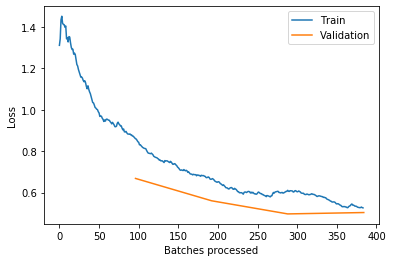

18_224f_lr_0.001_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.918932,0.691801,0.207207,0.792793,00:31
1,0.764671,0.638628,0.189189,0.810811,00:30
2,0.691792,0.621910,0.180180,0.819820,00:30
3,0.598233,0.646570,0.180180,0.819820,00:30


Better model found at epoch 0 with accuracy value: 0.792792797088623.
Better model found at epoch 1 with accuracy value: 0.8108108043670654.
Better model found at epoch 2 with accuracy value: 0.8198198080062866.


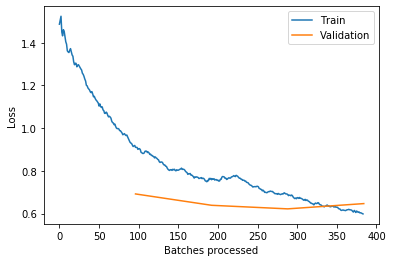

18_224f_lr_0.0003_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.149896,0.646234,0.247748,0.752252,00:31
1,0.839848,0.588394,0.189189,0.810811,00:31
2,0.745095,0.596285,0.184685,0.815315,00:31
3,0.736156,0.577243,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.7522522807121277.
Better model found at epoch 1 with accuracy value: 0.8108108043670654.
Better model found at epoch 2 with accuracy value: 0.815315306186676.


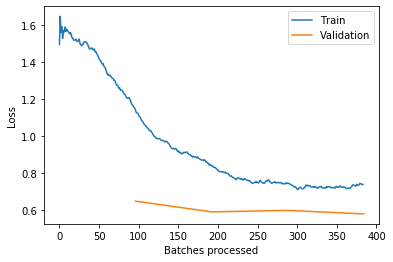

saved stats to: stats\18_224f_stats.p


In [23]:
for key, params in get_params(all_cycles=[4], all_lr=[3e-3, 1e-3, 3e-4]):
    do_train(key, **params)
all_stats.save()

In [24]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.149  med: 0.180   Loss -- best: 0.504  med: 0.596

18_224f_lr_0.003_cyc_4  error_rate: 0.149   accuracy: 0.851   loss:0.5037
18_224f_lr_0.001_cyc_4  error_rate: 0.180   accuracy: 0.820   loss:0.6219
18_224f_lr_0.0003_cyc_4  error_rate: 0.185   accuracy: 0.815   loss:0.5963


18_224f_lr_0.003_cyc_4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.023913,0.686292,0.292793,0.707207,00:31
1,0.858235,0.504332,0.171171,0.828829,00:30
2,0.774068,0.568920,0.175676,0.824324,00:30
3,0.728937,0.580984,0.166667,0.833333,00:31


Better model found at epoch 0 with accuracy value: 0.707207202911377.
Better model found at epoch 1 with accuracy value: 0.8288288116455078.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.


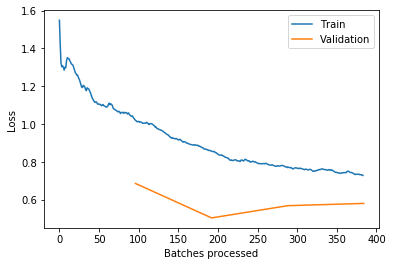

18_224f_lr_0.001_cyc_4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.077440,0.631814,0.211712,0.788288,00:31
1,0.948686,0.616329,0.220721,0.779279,00:31
2,0.864051,0.602679,0.193694,0.806306,00:32
3,0.817533,0.575271,0.180180,0.819820,00:32


Better model found at epoch 0 with accuracy value: 0.7882882952690125.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 3 with accuracy value: 0.8198198080062866.


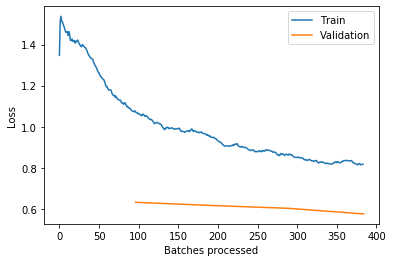

18_224f_lr_0.0003_cyc_4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.201201,0.720834,0.288288,0.711712,00:32
1,1.018826,0.680925,0.252252,0.747748,00:31
2,0.942902,0.644212,0.229730,0.770270,00:32
3,0.915680,0.647043,0.238739,0.761261,00:31


Better model found at epoch 0 with accuracy value: 0.7117117047309875.
Better model found at epoch 1 with accuracy value: 0.7477477192878723.
Better model found at epoch 2 with accuracy value: 0.7702702879905701.


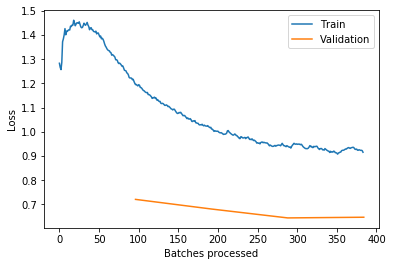

saved stats to: stats\18_224f_stats.p


In [25]:
for key, params in get_params(all_cycles=[4], all_lr=[3e-3, 1e-3, 3e-4]):
    do_train(key, mixup=True, **params)
all_stats.save()

In [26]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.149  med: 0.180   Loss -- best: 0.504  med: 0.589

18_224f_lr_0.003_cyc_4  error_rate: 0.149   accuracy: 0.851   loss:0.5037
18_224f_lr_0.003_cyc_4_m  error_rate: 0.167   accuracy: 0.833   loss:0.5810
18_224f_lr_0.001_cyc_4  error_rate: 0.180   accuracy: 0.820   loss:0.6219
18_224f_lr_0.001_cyc_4_m  error_rate: 0.180   accuracy: 0.820   loss:0.5753
18_224f_lr_0.0003_cyc_4  error_rate: 0.185   accuracy: 0.815   loss:0.5963
18_224f_lr_0.0003_cyc_4_m  error_rate: 0.230   accuracy: 0.770   loss:0.6442


18_224f_lr_0.003_cyc_4_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.940004,0.590213,0.198198,0.801802,00:31
1,0.799246,0.656869,0.184685,0.815315,00:31
2,0.732368,0.550587,0.157658,0.842342,00:31
3,0.685030,0.575987,0.198198,0.801802,00:31


Better model found at epoch 0 with accuracy value: 0.8018018007278442.
Better model found at epoch 1 with accuracy value: 0.815315306186676.
Better model found at epoch 2 with accuracy value: 0.8423423171043396.


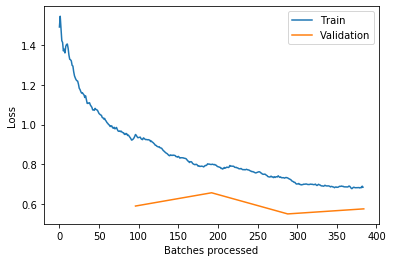

18_224f_lr_0.001_cyc_4_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.998984,0.715248,0.261261,0.738739,00:30
1,0.852380,0.611935,0.211712,0.788288,00:32
2,0.784307,0.678550,0.211712,0.788288,00:32
3,0.782606,0.679638,0.225225,0.774775,00:32


Better model found at epoch 0 with accuracy value: 0.7387387156486511.
Better model found at epoch 1 with accuracy value: 0.7882882952690125.


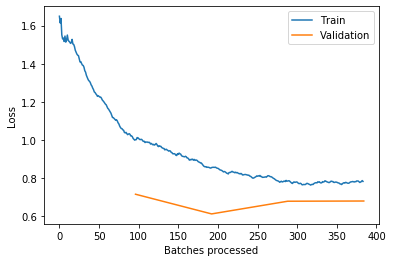

18_224f_lr_0.0003_cyc_4_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.157770,0.711950,0.252252,0.747748,00:32
1,0.958539,0.640121,0.216216,0.783784,00:32
2,0.858831,0.633297,0.220721,0.779279,00:32
3,0.855342,0.656395,0.207207,0.792793,00:31


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 1 with accuracy value: 0.7837837934494019.
Better model found at epoch 3 with accuracy value: 0.792792797088623.


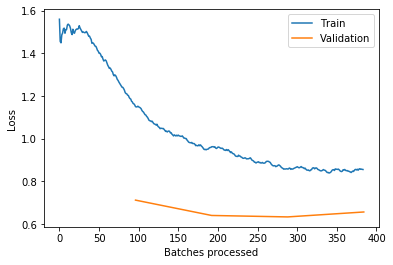

saved stats to: stats\18_224f_stats.p


In [27]:
for key, params in get_params(all_cycles=[4], all_lr=[3e-3, 1e-3, 3e-4]):
    do_train(key, mixup=0.2, **params)
all_stats.save()

In [28]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.149  med: 0.180   Loss -- best: 0.504  med: 0.596

18_224f_lr_0.003_cyc_4  error_rate: 0.149   accuracy: 0.851   loss:0.5037
18_224f_lr_0.003_cyc_4_m0.2  error_rate: 0.158   accuracy: 0.842   loss:0.5506
18_224f_lr_0.003_cyc_4_m  error_rate: 0.167   accuracy: 0.833   loss:0.5810
18_224f_lr_0.001_cyc_4  error_rate: 0.180   accuracy: 0.820   loss:0.6219
18_224f_lr_0.001_cyc_4_m  error_rate: 0.180   accuracy: 0.820   loss:0.5753
18_224f_lr_0.0003_cyc_4  error_rate: 0.185   accuracy: 0.815   loss:0.5963
18_224f_lr_0.0003_cyc_4_m0.2  error_rate: 0.207   accuracy: 0.793   loss:0.6564
18_224f_lr_0.001_cyc_4_m0.2  error_rate: 0.212   accuracy: 0.788   loss:0.6119
18_224f_lr_0.0003_cyc_4_m  error_rate: 0.230   accuracy: 0.770   loss:0.6442


18_224f_lr_0.001_cyc_4_ps_0.4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.042125,0.686589,0.256757,0.743243,00:31
1,0.925977,0.595545,0.198198,0.801802,00:31
2,0.839987,0.594686,0.216216,0.783784,00:31
3,0.815881,0.615465,0.193694,0.806306,00:31


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.
Better model found at epoch 3 with accuracy value: 0.8063063025474548.


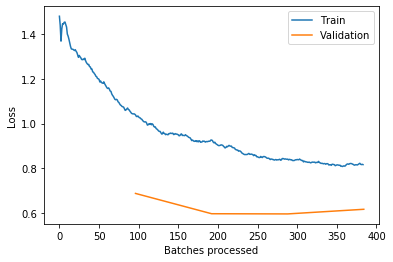

18_224f_lr_0.001_cyc_4_ps_0.5_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.073562,0.608556,0.198198,0.801802,00:31
1,0.939605,0.579312,0.171171,0.828829,00:31
2,0.860663,0.566737,0.180180,0.819820,00:31
3,0.809393,0.560435,0.171171,0.828829,00:30


Better model found at epoch 0 with accuracy value: 0.8018018007278442.
Better model found at epoch 1 with accuracy value: 0.8288288116455078.


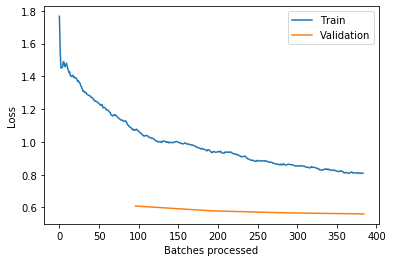

18_224f_lr_0.001_cyc_4_ps_0.6_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.141153,0.648101,0.211712,0.788288,00:30
1,1.005564,0.624117,0.198198,0.801802,00:31
2,0.890570,0.625725,0.207207,0.792793,00:30
3,0.883101,0.591968,0.175676,0.824324,00:30


Better model found at epoch 0 with accuracy value: 0.7882882952690125.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.
Better model found at epoch 3 with accuracy value: 0.8243243098258972.


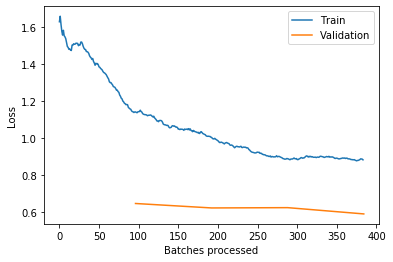

18_224f_lr_0.001_cyc_4_ps_0.7_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.256847,0.642622,0.216216,0.783784,00:31
1,1.038805,0.599319,0.180180,0.819820,00:31
2,0.934244,0.614859,0.184685,0.815315,00:31
3,0.879567,0.594645,0.171171,0.828829,00:31


Better model found at epoch 0 with accuracy value: 0.7837837934494019.
Better model found at epoch 1 with accuracy value: 0.8198198080062866.
Better model found at epoch 3 with accuracy value: 0.8288288116455078.


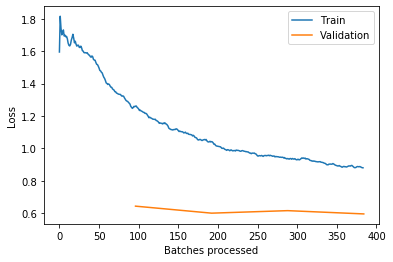

18_224f_lr_0.001_cyc_4_ps_0.8_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.504285,0.636496,0.225225,0.774775,00:30
1,1.150143,0.603803,0.189189,0.810811,00:31
2,1.016487,0.593719,0.184685,0.815315,00:31
3,0.960876,0.583310,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.7747747898101807.
Better model found at epoch 1 with accuracy value: 0.8108108043670654.
Better model found at epoch 2 with accuracy value: 0.815315306186676.


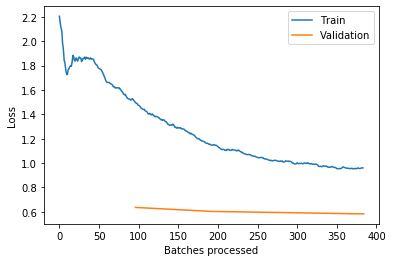

18_224f_lr_0.001_cyc_4_ps_0.85_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.585688,0.688050,0.247748,0.752252,00:30
1,1.246856,0.630549,0.207207,0.792793,00:31
2,1.046227,0.634027,0.216216,0.783784,00:31
3,0.998777,0.638903,0.225225,0.774775,00:30


Better model found at epoch 0 with accuracy value: 0.7522522807121277.
Better model found at epoch 1 with accuracy value: 0.792792797088623.


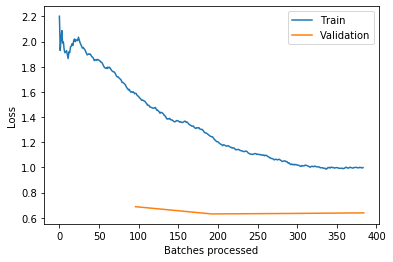

18_224f_lr_0.001_cyc_4_ps_0.9_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.902890,0.677586,0.229730,0.770270,00:31
1,1.443646,0.617075,0.180180,0.819820,00:31
2,1.168966,0.620959,0.207207,0.792793,00:31
3,1.097472,0.611608,0.184685,0.815315,00:31


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 1 with accuracy value: 0.8198198080062866.


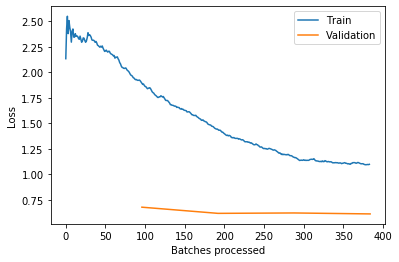

saved stats to: stats\18_224f_stats.p


In [29]:
for key, params in get_params(all_cycles=[4], all_lr=[1e-3]):
    for ps in [0.4,0.5, 0.6, 0.7, 0.8, 0.85, 0.9]:
        do_train(key, mixup=True, ps=ps, **params)
all_stats.save()

In [30]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.149  med: 0.180   Loss -- best: 0.504  med: 0.595

18_224f_lr_0.003_cyc_4  error_rate: 0.149   accuracy: 0.851   loss:0.5037
18_224f_lr_0.003_cyc_4_m0.2  error_rate: 0.158   accuracy: 0.842   loss:0.5506
18_224f_lr_0.003_cyc_4_m  error_rate: 0.167   accuracy: 0.833   loss:0.5810
18_224f_lr_0.001_cyc_4_ps_0.5_m  error_rate: 0.171   accuracy: 0.829   loss:0.5604
18_224f_lr_0.001_cyc_4_ps_0.7_m  error_rate: 0.171   accuracy: 0.829   loss:0.5946
18_224f_lr_0.001_cyc_4_ps_0.6_m  error_rate: 0.176   accuracy: 0.824   loss:0.5920
18_224f_lr_0.001_cyc_4  error_rate: 0.180   accuracy: 0.820   loss:0.6219
18_224f_lr_0.001_cyc_4_m  error_rate: 0.180   accuracy: 0.820   loss:0.5753
18_224f_lr_0.001_cyc_4_ps_0.9_m  error_rate: 0.180   accuracy: 0.820   loss:0.6171
18_224f_lr_0.0003_cyc_4  error_rate: 0.185   accuracy: 0.815   loss:0.5963


### Try Label Smoothing

18_224f_lr_0.003_cyc_4_i0_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.019127,0.819797,0.265766,0.734234,00:31
1,0.803219,0.673538,0.202703,0.797297,00:32
2,0.724463,0.667197,0.139640,0.860360,00:31
3,0.679116,0.659873,0.153153,0.846847,00:31


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 1 with accuracy value: 0.7972972989082336.
Better model found at epoch 2 with accuracy value: 0.8603603839874268.


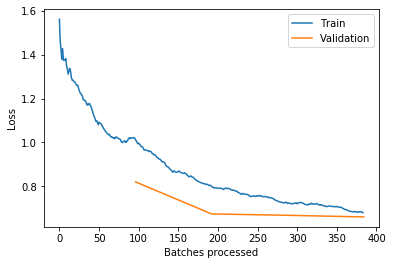

18_224f_lr_0.003_cyc_4_i1_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.967923,0.747742,0.180180,0.819820,00:31
1,0.805805,0.630351,0.166667,0.833333,00:31
2,0.713272,0.674814,0.166667,0.833333,00:32
3,0.680005,0.666526,0.157658,0.842342,00:32


Better model found at epoch 0 with accuracy value: 0.8198198080062866.
Better model found at epoch 1 with accuracy value: 0.8333333134651184.
Better model found at epoch 3 with accuracy value: 0.8423423171043396.


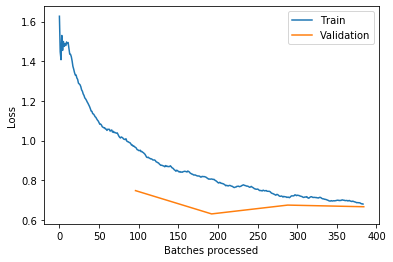

18_224f_lr_0.003_cyc_4_i2_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.976072,0.772211,0.207207,0.792793,00:31
1,0.790745,0.674199,0.189189,0.810811,00:31
2,0.723518,0.685773,0.144144,0.855856,00:31
3,0.680110,0.675559,0.144144,0.855856,00:31


Better model found at epoch 0 with accuracy value: 0.792792797088623.
Better model found at epoch 1 with accuracy value: 0.8108108043670654.
Better model found at epoch 2 with accuracy value: 0.8558558821678162.


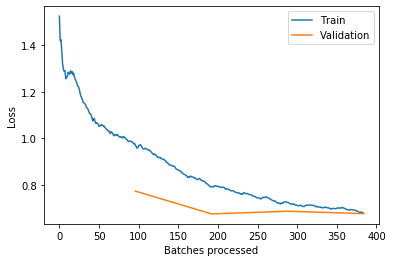

18_224f_lr_0.003_cyc_4_i3_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.990266,0.822657,0.247748,0.752252,00:31
1,0.819353,0.759622,0.247748,0.752252,00:31
2,0.738679,0.664162,0.153153,0.846847,00:31
3,0.702623,0.654300,0.175676,0.824324,00:31


Better model found at epoch 0 with accuracy value: 0.7522522807121277.
Better model found at epoch 2 with accuracy value: 0.8468468189239502.


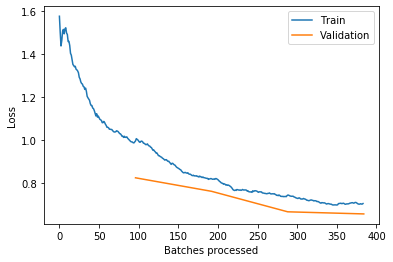

18_224f_lr_0.003_cyc_4_i4_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.991458,0.973117,0.324324,0.675676,00:31
1,0.814018,0.724751,0.184685,0.815315,00:31
2,0.746494,0.690008,0.198198,0.801802,00:31
3,0.690442,0.713589,0.175676,0.824324,00:32


Better model found at epoch 0 with accuracy value: 0.6756756901741028.
Better model found at epoch 1 with accuracy value: 0.815315306186676.
Better model found at epoch 3 with accuracy value: 0.8243243098258972.


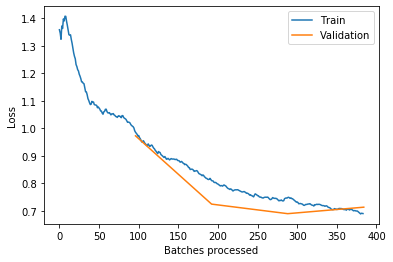

18_224f_lr_0.003_cyc_4_i5_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.015187,0.828637,0.229730,0.770270,00:31
1,0.812482,0.703611,0.189189,0.810811,00:30
2,0.729094,0.723002,0.211712,0.788288,00:31
3,0.696258,0.700661,0.189189,0.810811,00:32


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 1 with accuracy value: 0.8108108043670654.


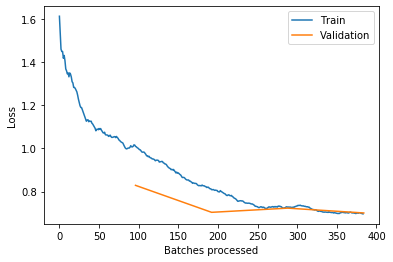

18_224f_lr_0.003_cyc_4_i6_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.952711,0.756413,0.256757,0.743243,00:32
1,0.805312,0.642652,0.157658,0.842342,00:31
2,0.722126,0.674446,0.198198,0.801802,00:31
3,0.680339,0.650033,0.166667,0.833333,00:32


Better model found at epoch 0 with accuracy value: 0.7432431578636169.
Better model found at epoch 1 with accuracy value: 0.8423423171043396.


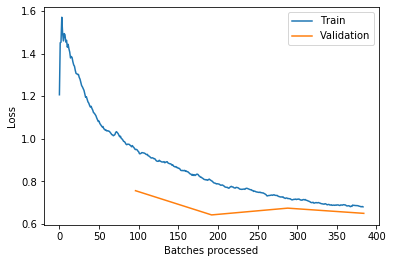

18_224f_lr_0.003_cyc_4_i7_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.969619,0.784918,0.256757,0.743243,00:31
1,0.804663,0.732474,0.225225,0.774775,00:30
2,0.728023,0.688035,0.202703,0.797297,00:31
3,0.688213,0.677306,0.175676,0.824324,00:31


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 1 with accuracy value: 0.7747747898101807.
Better model found at epoch 2 with accuracy value: 0.7972972989082336.
Better model found at epoch 3 with accuracy value: 0.8243243098258972.


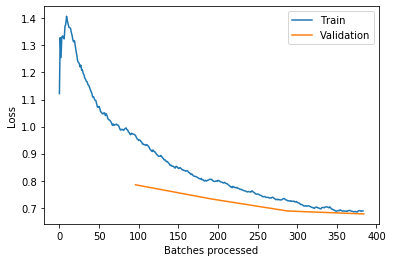

18_224f_lr_0.003_cyc_4_i8_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.960758,0.782803,0.229730,0.770270,00:31
1,0.806027,0.757138,0.238739,0.761261,00:32
2,0.718277,0.676935,0.148649,0.851351,00:31
3,0.691616,0.665320,0.171171,0.828829,00:32


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 2 with accuracy value: 0.8513513803482056.


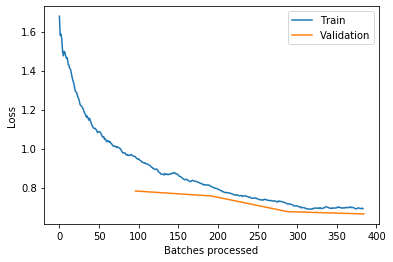

18_224f_lr_0.003_cyc_4_i9_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.991387,0.704449,0.198198,0.801802,00:31
1,0.802503,0.723356,0.184685,0.815315,00:31
2,0.728027,0.656335,0.166667,0.833333,00:32
3,0.691828,0.666656,0.144144,0.855856,00:31


Better model found at epoch 0 with accuracy value: 0.8018018007278442.
Better model found at epoch 1 with accuracy value: 0.815315306186676.
Better model found at epoch 2 with accuracy value: 0.8333333134651184.
Better model found at epoch 3 with accuracy value: 0.8558558821678162.


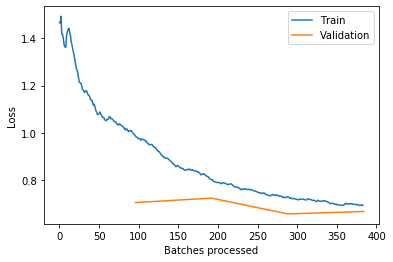

saved stats to: stats\18_224f_stats.p


In [33]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[3e-3]):
        key = f'{key}_i{i}_ls'
        do_train_ls(key, **params)
all_stats.save()

In [34]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.140  med: 0.176   Loss -- best: 0.504  med: 0.626

18_224f_lr_0.003_cyc_4_i0_ls_ls  error_rate: 0.140   accuracy: 0.860   loss:0.6672
18_224f_lr_0.003_cyc_4_i2_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6858
18_224f_lr_0.003_cyc_4_i9_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6667
18_224f_lr_0.003_cyc_4  error_rate: 0.149   accuracy: 0.851   loss:0.5037
18_224f_lr_0.003_cyc_4_i8_ls_ls  error_rate: 0.149   accuracy: 0.851   loss:0.6769
18_224f_lr_0.003_cyc_4_i3_ls_ls  error_rate: 0.153   accuracy: 0.847   loss:0.6642
18_224f_lr_0.003_cyc_4_m0.2  error_rate: 0.158   accuracy: 0.842   loss:0.5506
18_224f_lr_0.003_cyc_4_i1_ls_ls  error_rate: 0.158   accuracy: 0.842   loss:0.6665
18_224f_lr_0.003_cyc_4_i6_ls_ls  error_rate: 0.158   accuracy: 0.842   loss:0.6427
18_224f_lr_0.003_cyc_4_m  error_rate: 0.167   accuracy: 0.833   loss:0.5810


### Check for consistency

18_224f_lr_0.003_cyc_4_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.836146,0.621455,0.211712,0.788288,00:32
1,0.664268,0.638657,0.225225,0.774775,00:31
2,0.586715,0.559577,0.171171,0.828829,00:31
3,0.516989,0.575879,0.166667,0.833333,00:32


Better model found at epoch 0 with accuracy value: 0.7882882952690125.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.


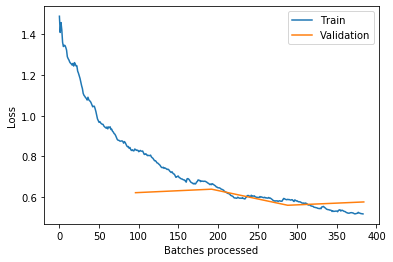

18_224f_lr_0.003_cyc_4_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.867113,0.643609,0.243243,0.756757,00:31
1,0.656504,0.584902,0.175676,0.824324,00:31
2,0.572563,0.600718,0.198198,0.801802,00:31
3,0.523953,0.571387,0.175676,0.824324,00:32


Better model found at epoch 0 with accuracy value: 0.7567567825317383.
Better model found at epoch 1 with accuracy value: 0.8243243098258972.


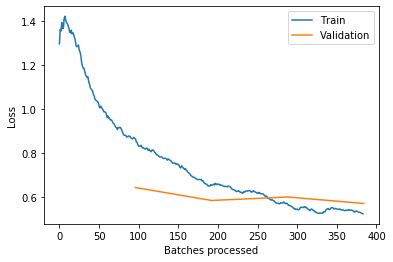

18_224f_lr_0.003_cyc_4_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.872989,0.786702,0.283784,0.716216,00:31
1,0.677066,0.614833,0.184685,0.815315,00:30
2,0.606542,0.577375,0.171171,0.828829,00:31
3,0.546546,0.646430,0.198198,0.801802,00:31


Better model found at epoch 0 with accuracy value: 0.7162162065505981.
Better model found at epoch 1 with accuracy value: 0.815315306186676.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.


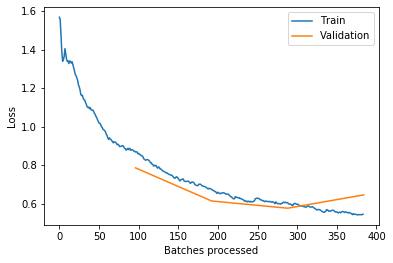

18_224f_lr_0.003_cyc_4_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.821845,0.673433,0.216216,0.783784,00:31
1,0.656399,0.587941,0.202703,0.797297,00:31
2,0.573823,0.727139,0.243243,0.756757,00:31
3,0.529365,0.728173,0.243243,0.756757,00:31


Better model found at epoch 0 with accuracy value: 0.7837837934494019.
Better model found at epoch 1 with accuracy value: 0.7972972989082336.


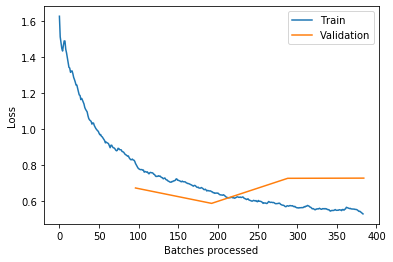

18_224f_lr_0.003_cyc_4_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.783868,0.720229,0.261261,0.738739,00:31
1,0.662371,0.791798,0.234234,0.765766,00:31
2,0.571261,0.637425,0.193694,0.806306,00:31
3,0.527908,0.611535,0.184685,0.815315,00:32


Better model found at epoch 0 with accuracy value: 0.7387387156486511.
Better model found at epoch 1 with accuracy value: 0.7657657861709595.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 3 with accuracy value: 0.815315306186676.


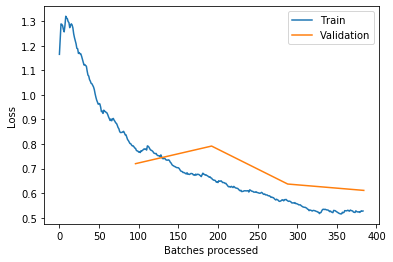

18_224f_lr_0.003_cyc_4_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.886901,0.711138,0.252252,0.747748,00:31
1,0.704178,0.730019,0.216216,0.783784,00:31
2,0.602825,0.551374,0.171171,0.828829,00:32
3,0.546565,0.577277,0.166667,0.833333,00:31


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 1 with accuracy value: 0.7837837934494019.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.


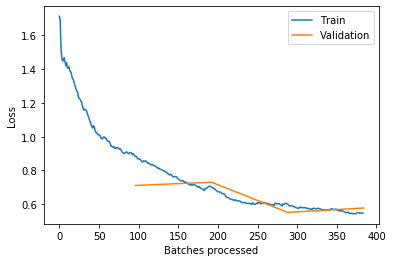

18_224f_lr_0.003_cyc_4_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.879435,0.694590,0.256757,0.743243,00:32
1,0.683054,0.524401,0.211712,0.788288,00:31
2,0.569414,0.565277,0.184685,0.815315,00:31
3,0.525168,0.508827,0.153153,0.846847,00:32


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 1 with accuracy value: 0.7882882952690125.
Better model found at epoch 2 with accuracy value: 0.815315306186676.
Better model found at epoch 3 with accuracy value: 0.8468468189239502.


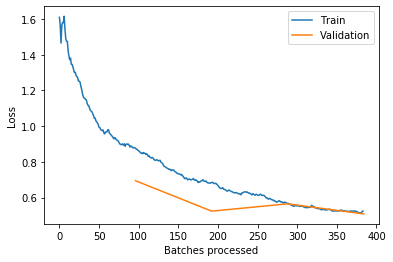

18_224f_lr_0.003_cyc_4_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.855287,0.548588,0.193694,0.806306,00:32
1,0.683133,0.476763,0.157658,0.842342,00:32
2,0.581032,0.660169,0.207207,0.792793,00:31
3,0.528861,0.619469,0.198198,0.801802,00:32


Better model found at epoch 0 with accuracy value: 0.8063063025474548.
Better model found at epoch 1 with accuracy value: 0.8423423171043396.


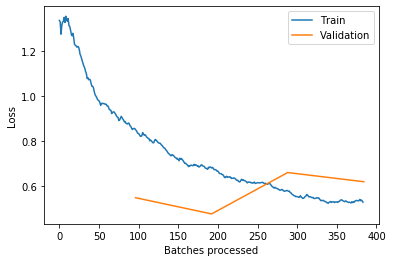

18_224f_lr_0.003_cyc_4_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.806276,0.711319,0.207207,0.792793,00:31
1,0.664314,0.812869,0.288288,0.711712,00:31
2,0.588873,0.688606,0.220721,0.779279,00:31
3,0.532821,0.758455,0.234234,0.765766,00:31


Better model found at epoch 0 with accuracy value: 0.792792797088623.


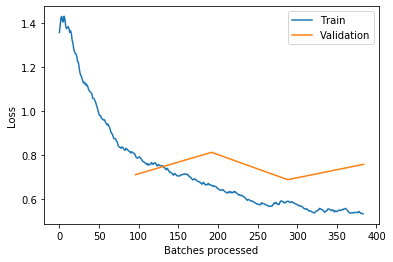

18_224f_lr_0.003_cyc_4_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.841191,0.710059,0.225225,0.774775,00:32
1,0.663086,0.829306,0.288288,0.711712,00:31
2,0.591747,0.719916,0.216216,0.783784,00:31
3,0.551556,0.653291,0.202703,0.797297,00:31


Better model found at epoch 0 with accuracy value: 0.7747747898101807.
Better model found at epoch 2 with accuracy value: 0.7837837934494019.
Better model found at epoch 3 with accuracy value: 0.7972972989082336.


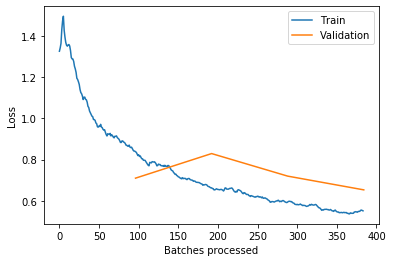

saved stats to: stats\18_224f_stats.p


In [35]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[3e-3]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [36]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.140  med: 0.176   Loss -- best: 0.477  med: 0.614

18_224f_lr_0.003_cyc_4_i0_ls_ls  error_rate: 0.140   accuracy: 0.860   loss:0.6672
18_224f_lr_0.003_cyc_4_i2_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6858
18_224f_lr_0.003_cyc_4_i9_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6667
18_224f_lr_0.003_cyc_4  error_rate: 0.149   accuracy: 0.851   loss:0.5037
18_224f_lr_0.003_cyc_4_i8_ls_ls  error_rate: 0.149   accuracy: 0.851   loss:0.6769
18_224f_lr_0.003_cyc_4_i6  error_rate: 0.153   accuracy: 0.847   loss:0.5088
18_224f_lr_0.003_cyc_4_i3_ls_ls  error_rate: 0.153   accuracy: 0.847   loss:0.6642
18_224f_lr_0.003_cyc_4_i7  error_rate: 0.158   accuracy: 0.842   loss:0.4768
18_224f_lr_0.003_cyc_4_m0.2  error_rate: 0.158   accuracy: 0.842   loss:0.5506
18_224f_lr_0.003_cyc_4_i1_ls_ls  error_rate: 0.158   accuracy: 0.842   loss:0.6665


### Combined Mixup-0.2 and Label Smoothing

18_224f_lr_0.003_cyc_4_i0_ls_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.067052,0.753990,0.238739,0.761261,00:32
1,0.907331,0.711983,0.211712,0.788288,00:31
2,0.820352,0.674889,0.171171,0.828829,00:32
3,0.785346,0.664662,0.157658,0.842342,00:31


Better model found at epoch 0 with accuracy value: 0.7612612843513489.
Better model found at epoch 1 with accuracy value: 0.7882882952690125.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.
Better model found at epoch 3 with accuracy value: 0.8423423171043396.


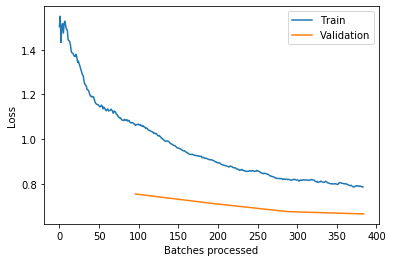

18_224f_lr_0.003_cyc_4_i1_ls_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.053542,0.903591,0.337838,0.662162,00:31
1,0.899044,0.694065,0.198198,0.801802,00:31
2,0.828250,0.682741,0.184685,0.815315,00:31
3,0.790805,0.674356,0.184685,0.815315,00:31


Better model found at epoch 0 with accuracy value: 0.662162184715271.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.
Better model found at epoch 2 with accuracy value: 0.815315306186676.


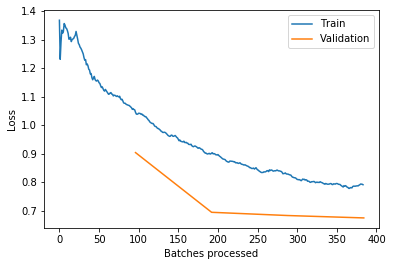

18_224f_lr_0.003_cyc_4_i2_ls_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.109284,0.737022,0.243243,0.756757,00:31
1,0.895227,0.691022,0.175676,0.824324,00:31
2,0.822895,0.682694,0.166667,0.833333,00:31
3,0.785421,0.677022,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.7567567825317383.
Better model found at epoch 1 with accuracy value: 0.8243243098258972.
Better model found at epoch 2 with accuracy value: 0.8333333134651184.


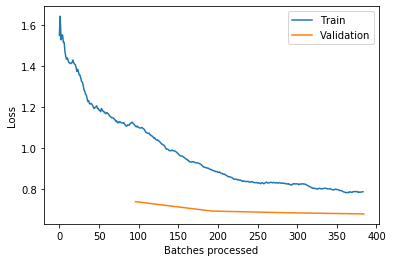

18_224f_lr_0.003_cyc_4_i3_ls_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.075631,0.716801,0.238739,0.761261,00:31
1,0.898319,0.683176,0.166667,0.833333,00:31
2,0.818366,0.702919,0.180180,0.819820,00:31
3,0.787325,0.679635,0.207207,0.792793,00:31


Better model found at epoch 0 with accuracy value: 0.7612612843513489.
Better model found at epoch 1 with accuracy value: 0.8333333134651184.


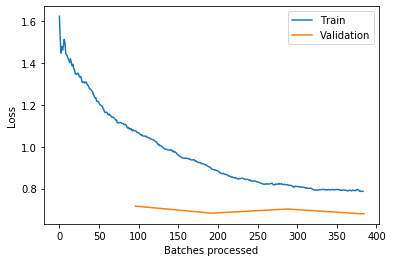

18_224f_lr_0.003_cyc_4_i4_ls_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.085392,0.855190,0.301802,0.698198,00:32
1,0.900245,0.672253,0.189189,0.810811,00:31
2,0.833915,0.701878,0.198198,0.801802,00:31
3,0.781464,0.674606,0.184685,0.815315,00:31


Better model found at epoch 0 with accuracy value: 0.6981981992721558.
Better model found at epoch 1 with accuracy value: 0.8108108043670654.
Better model found at epoch 3 with accuracy value: 0.815315306186676.


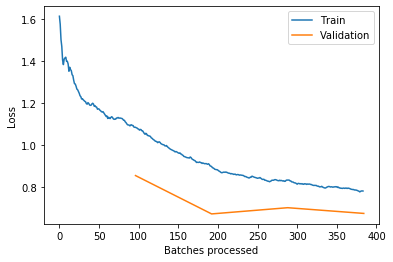

18_224f_lr_0.003_cyc_4_i5_ls_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.076630,0.839391,0.261261,0.738739,00:31
1,0.879387,0.676065,0.166667,0.833333,00:31
2,0.813909,0.670874,0.171171,0.828829,00:31
3,0.784048,0.686578,0.171171,0.828829,00:32


Better model found at epoch 0 with accuracy value: 0.7387387156486511.
Better model found at epoch 1 with accuracy value: 0.8333333134651184.


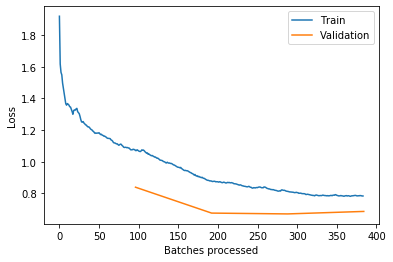

18_224f_lr_0.003_cyc_4_i6_ls_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.069124,0.769313,0.229730,0.770270,00:31
1,0.899460,0.681275,0.184685,0.815315,00:31
2,0.825164,0.685530,0.157658,0.842342,00:31
3,0.782469,0.662116,0.157658,0.842342,00:31


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 1 with accuracy value: 0.815315306186676.
Better model found at epoch 2 with accuracy value: 0.8423423171043396.


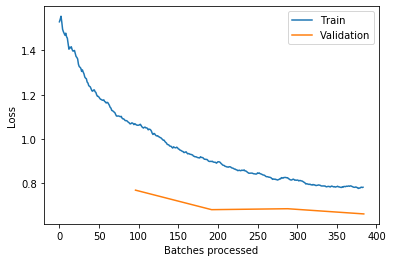

18_224f_lr_0.003_cyc_4_i7_ls_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.065988,0.769838,0.234234,0.765766,00:31
1,0.891056,0.706571,0.225225,0.774775,00:31
2,0.816039,0.684034,0.193694,0.806306,00:31
3,0.788649,0.626295,0.162162,0.837838,00:31


Better model found at epoch 0 with accuracy value: 0.7657657861709595.
Better model found at epoch 1 with accuracy value: 0.7747747898101807.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 3 with accuracy value: 0.837837815284729.


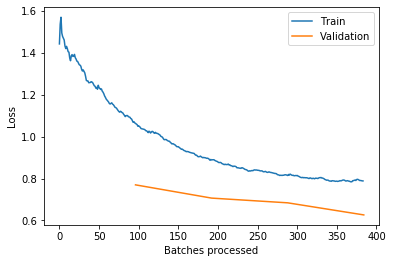

18_224f_lr_0.003_cyc_4_i8_ls_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.045222,0.748666,0.207207,0.792793,00:31
1,0.888357,0.715345,0.198198,0.801802,00:31
2,0.806040,0.711087,0.189189,0.810811,00:31
3,0.773518,0.705809,0.180180,0.819820,00:31


Better model found at epoch 0 with accuracy value: 0.792792797088623.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.
Better model found at epoch 2 with accuracy value: 0.8108108043670654.
Better model found at epoch 3 with accuracy value: 0.8198198080062866.


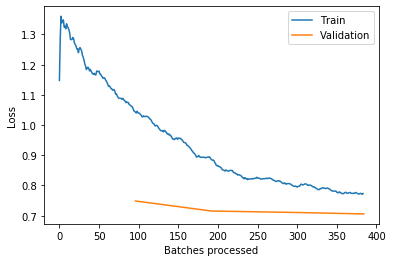

18_224f_lr_0.003_cyc_4_i9_ls_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.051604,0.846816,0.279279,0.720721,00:36
1,0.887302,0.740211,0.243243,0.756757,00:30
2,0.807860,0.676308,0.171171,0.828829,00:31
3,0.778614,0.672382,0.175676,0.824324,00:31


Better model found at epoch 0 with accuracy value: 0.7207207083702087.
Better model found at epoch 1 with accuracy value: 0.7567567825317383.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.


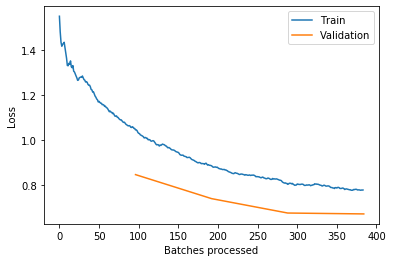

saved stats to: stats\18_224f_stats.p


In [37]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[3e-3]):
        key = f'{key}_i{i}_ls'
        do_train_ls(key, mixup=0.2, **params)
all_stats.save()

In [38]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.140  med: 0.171   Loss -- best: 0.477  med: 0.637

18_224f_lr_0.003_cyc_4_i0_ls_ls  error_rate: 0.140   accuracy: 0.860   loss:0.6672
18_224f_lr_0.003_cyc_4_i2_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6858
18_224f_lr_0.003_cyc_4_i9_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6667
18_224f_lr_0.003_cyc_4  error_rate: 0.149   accuracy: 0.851   loss:0.5037
18_224f_lr_0.003_cyc_4_i8_ls_ls  error_rate: 0.149   accuracy: 0.851   loss:0.6769
18_224f_lr_0.003_cyc_4_i6  error_rate: 0.153   accuracy: 0.847   loss:0.5088
18_224f_lr_0.003_cyc_4_i3_ls_ls  error_rate: 0.153   accuracy: 0.847   loss:0.6642
18_224f_lr_0.003_cyc_4_i7  error_rate: 0.158   accuracy: 0.842   loss:0.4768
18_224f_lr_0.003_cyc_4_i0_ls_ls_m0.2  error_rate: 0.158   accuracy: 0.842   loss:0.6647
18_224f_lr_0.003_cyc_4_m0.2  error_rate: 0.158   accuracy: 0.842   loss:0.5506


18_224f_lr_0.01_cyc_4_i0_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.932334,0.813705,0.265766,0.734234,00:31
1,0.827132,0.948919,0.427928,0.572072,00:32
2,0.726528,0.831059,0.252252,0.747748,00:31
3,0.670113,0.849741,0.288288,0.711712,00:30


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 2 with accuracy value: 0.7477477192878723.


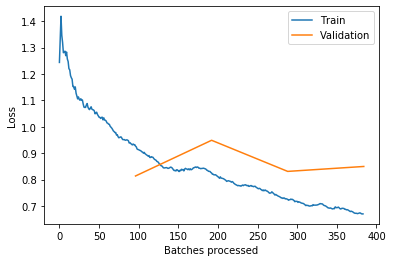

18_224f_lr_0.01_cyc_4_i1_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.911236,0.705127,0.225225,0.774775,00:30
1,0.802414,0.850819,0.306306,0.693694,00:31
2,0.720351,0.757856,0.202703,0.797297,00:31
3,0.680926,0.839087,0.243243,0.756757,00:31


Better model found at epoch 0 with accuracy value: 0.7747747898101807.
Better model found at epoch 2 with accuracy value: 0.7972972989082336.


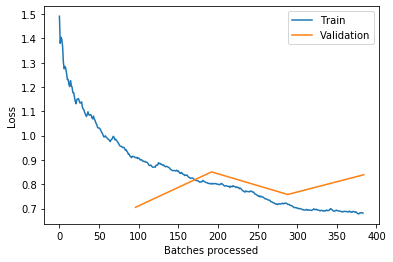

18_224f_lr_0.01_cyc_4_i2_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.914593,0.736109,0.265766,0.734234,00:30
1,0.808523,0.630809,0.175676,0.824324,00:30
2,0.739585,0.694711,0.166667,0.833333,00:31
3,0.687988,0.674935,0.162162,0.837838,00:31


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 1 with accuracy value: 0.8243243098258972.
Better model found at epoch 2 with accuracy value: 0.8333333134651184.
Better model found at epoch 3 with accuracy value: 0.837837815284729.


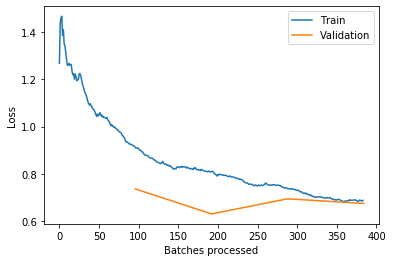

18_224f_lr_0.01_cyc_4_i3_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.921852,0.719343,0.202703,0.797297,00:31
1,0.803256,0.709588,0.175676,0.824324,00:30
2,0.736842,0.754204,0.220721,0.779279,00:32
3,0.672350,0.724824,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.7972972989082336.
Better model found at epoch 1 with accuracy value: 0.8243243098258972.


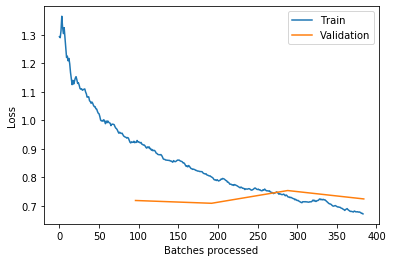

18_224f_lr_0.01_cyc_4_i4_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.889446,0.751578,0.234234,0.765766,00:31
1,0.811921,0.799916,0.247748,0.752252,00:31
2,0.725576,0.626964,0.148649,0.851351,00:30
3,0.670895,0.728814,0.225225,0.774775,00:31


Better model found at epoch 0 with accuracy value: 0.7657657861709595.
Better model found at epoch 2 with accuracy value: 0.8513513803482056.


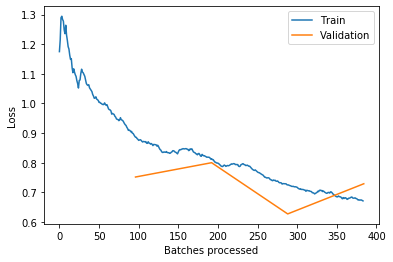

18_224f_lr_0.01_cyc_4_i5_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.928879,0.800967,0.252252,0.747748,00:30
1,0.803003,0.965333,0.391892,0.608108,00:30
2,0.733185,0.757866,0.193694,0.806306,00:30
3,0.676540,0.721824,0.202703,0.797297,00:31


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.


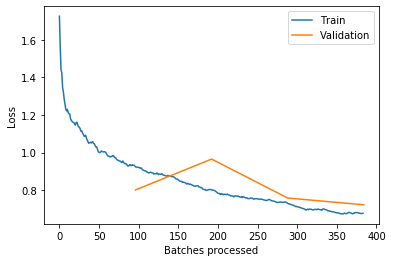

18_224f_lr_0.01_cyc_4_i6_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.939077,0.781529,0.243243,0.756757,00:31
1,0.827278,0.704051,0.207207,0.792793,00:30
2,0.730541,0.732307,0.193694,0.806306,00:31
3,0.675245,0.718376,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.7567567825317383.
Better model found at epoch 1 with accuracy value: 0.792792797088623.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 3 with accuracy value: 0.8108108043670654.


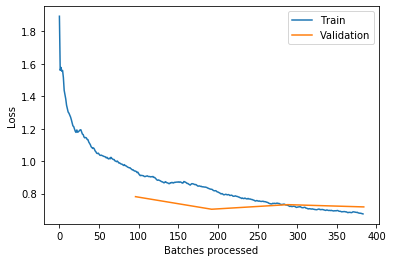

18_224f_lr_0.01_cyc_4_i7_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.913811,0.739270,0.234234,0.765766,00:31
1,0.821307,0.838863,0.243243,0.756757,00:31
2,0.724744,0.772238,0.216216,0.783784,00:31
3,0.689555,0.722419,0.225225,0.774775,00:31


Better model found at epoch 0 with accuracy value: 0.7657657861709595.
Better model found at epoch 2 with accuracy value: 0.7837837934494019.


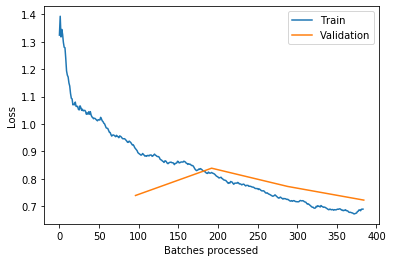

18_224f_lr_0.01_cyc_4_i8_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.915475,0.723819,0.211712,0.788288,00:31
1,0.794846,0.800608,0.252252,0.747748,00:31
2,0.728036,0.708687,0.202703,0.797297,00:31
3,0.674458,0.729236,0.211712,0.788288,00:30


Better model found at epoch 0 with accuracy value: 0.7882882952690125.
Better model found at epoch 2 with accuracy value: 0.7972972989082336.


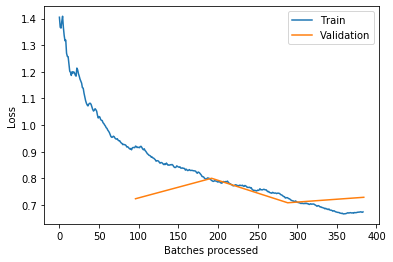

18_224f_lr_0.01_cyc_4_i9_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.888851,0.929680,0.315315,0.684685,00:30
1,0.828049,0.710540,0.193694,0.806306,00:31
2,0.727067,0.710940,0.211712,0.788288,00:30
3,0.669657,0.752226,0.243243,0.756757,00:31


Better model found at epoch 0 with accuracy value: 0.684684693813324.
Better model found at epoch 1 with accuracy value: 0.8063063025474548.


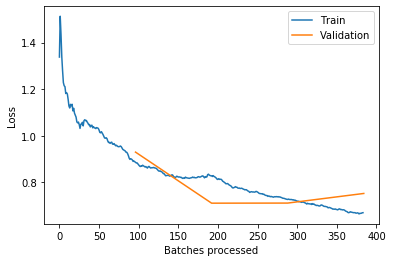

saved stats to: stats\18_224f_stats.p


In [39]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[1e-2]):
        key = f'{key}_i{i}'
        do_train_ls(key, **params)
all_stats.save()

18_224f_lr_0.01_cyc_4_i0_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.990336,0.820085,0.310811,0.689189,00:31
1,0.891860,0.693067,0.198198,0.801802,00:30
2,0.812191,0.670763,0.184685,0.815315,00:31
3,0.765554,0.664108,0.166667,0.833333,00:31


Better model found at epoch 0 with accuracy value: 0.6891891956329346.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.
Better model found at epoch 2 with accuracy value: 0.815315306186676.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.


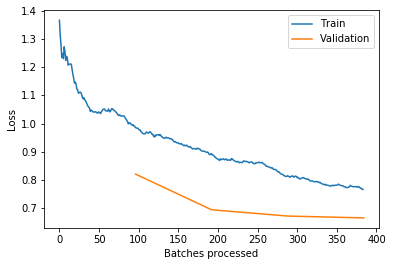

18_224f_lr_0.01_cyc_4_i1_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.010341,0.843679,0.288288,0.711712,00:30
1,0.896632,0.676141,0.202703,0.797297,00:31
2,0.808120,0.665309,0.166667,0.833333,00:31
3,0.786182,0.642340,0.157658,0.842342,00:31


Better model found at epoch 0 with accuracy value: 0.7117117047309875.
Better model found at epoch 1 with accuracy value: 0.7972972989082336.
Better model found at epoch 2 with accuracy value: 0.8333333134651184.
Better model found at epoch 3 with accuracy value: 0.8423423171043396.


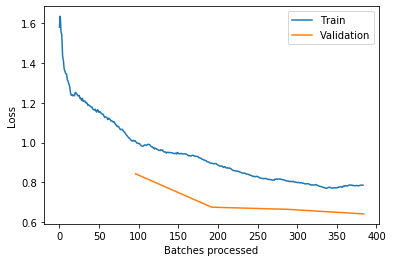

18_224f_lr_0.01_cyc_4_i2_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.966664,0.810984,0.360360,0.639640,00:30
1,0.895833,0.884662,0.418919,0.581081,00:31
2,0.818863,0.657754,0.166667,0.833333,00:31
3,0.777532,0.664477,0.162162,0.837838,00:31


Better model found at epoch 0 with accuracy value: 0.6396396160125732.
Better model found at epoch 2 with accuracy value: 0.8333333134651184.
Better model found at epoch 3 with accuracy value: 0.837837815284729.


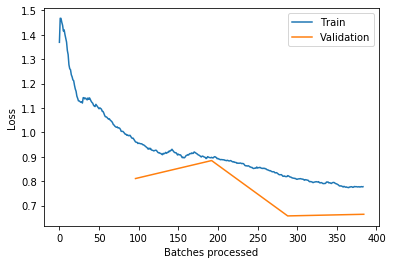

18_224f_lr_0.01_cyc_4_i3_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.000910,0.788180,0.274775,0.725225,00:30
1,0.895696,0.739743,0.238739,0.761261,00:30
2,0.817364,0.684536,0.171171,0.828829,00:31
3,0.783854,0.657896,0.144144,0.855856,00:31


Better model found at epoch 0 with accuracy value: 0.7252252101898193.
Better model found at epoch 1 with accuracy value: 0.7612612843513489.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.
Better model found at epoch 3 with accuracy value: 0.8558558821678162.


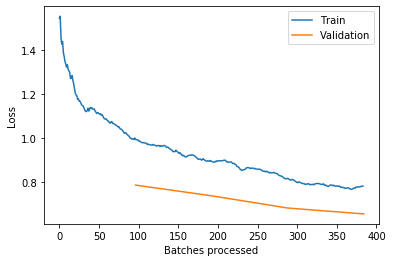

18_224f_lr_0.01_cyc_4_i4_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.995852,0.811387,0.256757,0.743243,00:30
1,0.896425,0.724733,0.207207,0.792793,00:31
2,0.816527,0.710163,0.198198,0.801802,00:31
3,0.776508,0.713577,0.198198,0.801802,00:31


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 1 with accuracy value: 0.792792797088623.
Better model found at epoch 2 with accuracy value: 0.8018018007278442.


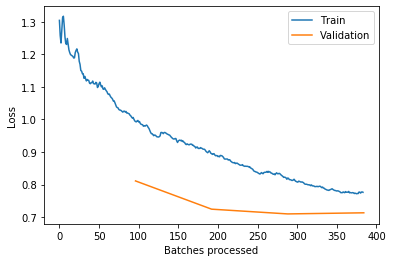

18_224f_lr_0.01_cyc_4_i5_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.997643,0.872241,0.274775,0.725225,00:30
1,0.924688,0.887403,0.337838,0.662162,00:31
2,0.821527,0.721094,0.220721,0.779279,00:30
3,0.769521,0.697268,0.166667,0.833333,00:30


Better model found at epoch 0 with accuracy value: 0.7252252101898193.
Better model found at epoch 2 with accuracy value: 0.7792792916297913.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.


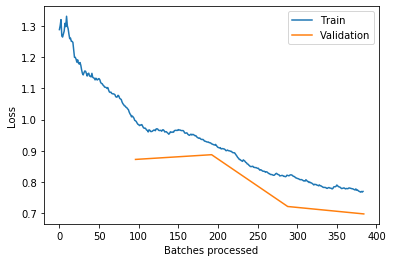

18_224f_lr_0.01_cyc_4_i6_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.010734,0.960245,0.288288,0.711712,00:31
1,0.900886,0.733326,0.220721,0.779279,00:31
2,0.826675,0.751756,0.220721,0.779279,00:31
3,0.788300,0.692307,0.166667,0.833333,00:31


Better model found at epoch 0 with accuracy value: 0.7117117047309875.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.


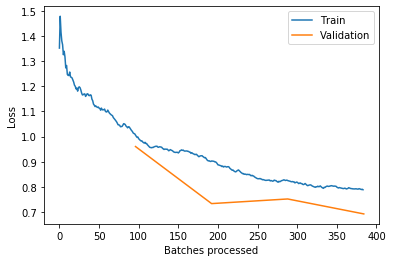

18_224f_lr_0.01_cyc_4_i7_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.005904,0.861331,0.369369,0.630631,00:31
1,0.907702,0.780621,0.265766,0.734234,00:30
2,0.814802,0.724887,0.234234,0.765766,00:31
3,0.763527,0.699654,0.184685,0.815315,00:31


Better model found at epoch 0 with accuracy value: 0.630630612373352.
Better model found at epoch 1 with accuracy value: 0.7342342138290405.
Better model found at epoch 2 with accuracy value: 0.7657657861709595.
Better model found at epoch 3 with accuracy value: 0.815315306186676.


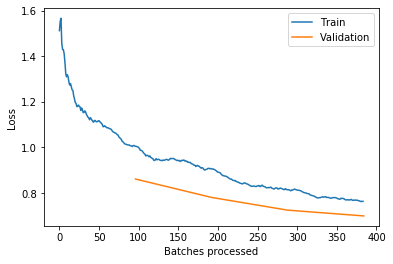

18_224f_lr_0.01_cyc_4_i8_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.992796,0.811515,0.288288,0.711712,00:31
1,0.861333,0.685995,0.220721,0.779279,00:31
2,0.809304,0.777716,0.247748,0.752252,00:30
3,0.782356,0.766469,0.207207,0.792793,00:31


Better model found at epoch 0 with accuracy value: 0.7117117047309875.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.
Better model found at epoch 3 with accuracy value: 0.792792797088623.


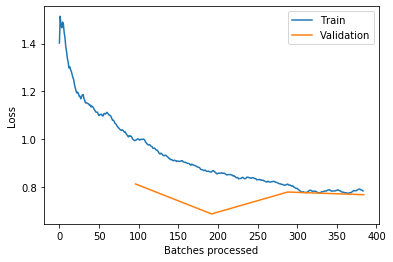

18_224f_lr_0.01_cyc_4_i9_ls_m0.2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.997805,1.099047,0.355856,0.644144,00:31
1,0.874337,0.813974,0.297297,0.702703,00:31
2,0.809306,0.704030,0.220721,0.779279,00:30
3,0.764487,0.771723,0.243243,0.756757,00:30


Better model found at epoch 0 with accuracy value: 0.6441441178321838.
Better model found at epoch 1 with accuracy value: 0.7027027010917664.
Better model found at epoch 2 with accuracy value: 0.7792792916297913.


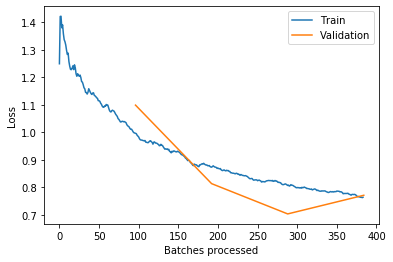

saved stats to: stats\18_224f_stats.p


In [40]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[1e-2]):
        key = f'{key}_i{i}'
        do_train_ls(key, mixup=0.2, **params)
all_stats.save()

In [41]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.140  med: 0.176   Loss -- best: 0.477  med: 0.665

18_224f_lr_0.003_cyc_4_i0_ls_ls  error_rate: 0.140   accuracy: 0.860   loss:0.6672
18_224f_lr_0.003_cyc_4_i2_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6858
18_224f_lr_0.003_cyc_4_i9_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6667
18_224f_lr_0.01_cyc_4_i3_ls_m0.2  error_rate: 0.144   accuracy: 0.856   loss:0.6579
18_224f_lr_0.003_cyc_4  error_rate: 0.149   accuracy: 0.851   loss:0.5037
18_224f_lr_0.003_cyc_4_i8_ls_ls  error_rate: 0.149   accuracy: 0.851   loss:0.6769
18_224f_lr_0.01_cyc_4_i4_ls  error_rate: 0.149   accuracy: 0.851   loss:0.6270
18_224f_lr_0.003_cyc_4_i6  error_rate: 0.153   accuracy: 0.847   loss:0.5088
18_224f_lr_0.003_cyc_4_i3_ls_ls  error_rate: 0.153   accuracy: 0.847   loss:0.6642
18_224f_lr_0.003_cyc_4_i7  error_rate: 0.158   accuracy: 0.842   loss:0.4768


18_224f_lr_0.001_cyc_8_i0_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.106813,0.752730,0.225225,0.774775,00:31
1,0.913764,0.791970,0.256757,0.743243,00:31
2,0.855795,0.742603,0.225225,0.774775,00:31
3,0.774385,0.625400,0.144144,0.855856,00:31
4,0.746948,0.643277,0.162162,0.837838,00:31
5,0.704918,0.638057,0.157658,0.842342,00:31
6,0.700865,0.659917,0.175676,0.824324,00:31
7,0.697259,0.636854,0.162162,0.837838,00:31


Better model found at epoch 0 with accuracy value: 0.7747747898101807.
Better model found at epoch 3 with accuracy value: 0.8558558821678162.


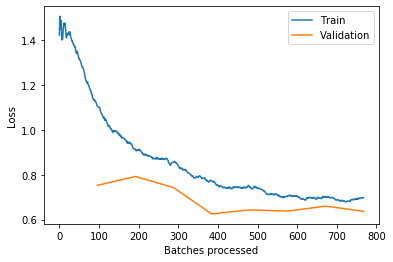

18_224f_lr_0.001_cyc_8_i1_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.094467,0.768721,0.247748,0.752252,00:31
1,0.929745,0.738387,0.220721,0.779279,00:31
2,0.821973,0.691041,0.193694,0.806306,00:30
3,0.767750,0.660019,0.184685,0.815315,00:31
4,0.740630,0.691931,0.162162,0.837838,00:31
5,0.706854,0.657359,0.162162,0.837838,00:30
6,0.689356,0.652452,0.166667,0.833333,00:31
7,0.679653,0.660370,0.171171,0.828829,00:31


Better model found at epoch 0 with accuracy value: 0.7522522807121277.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 3 with accuracy value: 0.815315306186676.
Better model found at epoch 4 with accuracy value: 0.837837815284729.


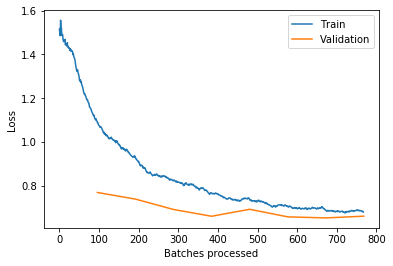

18_224f_lr_0.001_cyc_8_i2_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.076242,0.837727,0.283784,0.716216,00:30
1,0.936940,0.798053,0.247748,0.752252,00:31
2,0.858769,0.748298,0.234234,0.765766,00:31
3,0.774793,0.663661,0.171171,0.828829,00:31
4,0.721585,0.700083,0.162162,0.837838,00:31
5,0.720447,0.673947,0.162162,0.837838,00:30
6,0.713805,0.678937,0.162162,0.837838,00:31
7,0.684376,0.678471,0.171171,0.828829,00:31


Better model found at epoch 0 with accuracy value: 0.7162162065505981.
Better model found at epoch 1 with accuracy value: 0.7522522807121277.
Better model found at epoch 2 with accuracy value: 0.7657657861709595.
Better model found at epoch 3 with accuracy value: 0.8288288116455078.
Better model found at epoch 4 with accuracy value: 0.837837815284729.


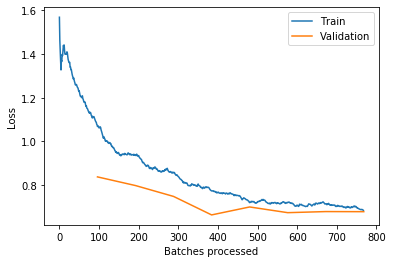

18_224f_lr_0.001_cyc_8_i3_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.122307,0.777998,0.238739,0.761261,00:31
1,0.939321,0.729833,0.225225,0.774775,00:30
2,0.837494,0.712003,0.171171,0.828829,00:31
3,0.787674,0.725222,0.162162,0.837838,00:31
4,0.730292,0.674649,0.175676,0.824324,00:31
5,0.727721,0.705414,0.180180,0.819820,00:31
6,0.695626,0.672095,0.157658,0.842342,00:30
7,0.692849,0.661984,0.157658,0.842342,00:30


Better model found at epoch 0 with accuracy value: 0.7612612843513489.
Better model found at epoch 1 with accuracy value: 0.7747747898101807.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.
Better model found at epoch 3 with accuracy value: 0.837837815284729.
Better model found at epoch 6 with accuracy value: 0.8423423171043396.


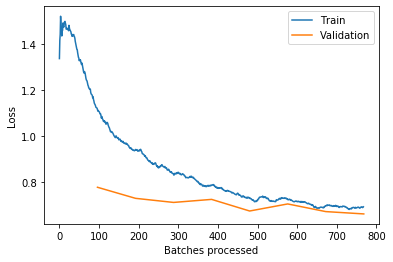

18_224f_lr_0.001_cyc_8_i4_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.052922,0.809581,0.238739,0.761261,00:31
1,0.894612,0.807109,0.229730,0.770270,00:31
2,0.832902,0.723053,0.180180,0.819820,00:30
3,0.763879,0.673558,0.180180,0.819820,00:31
4,0.725492,0.671423,0.175676,0.824324,00:31
5,0.701967,0.643867,0.144144,0.855856,00:31
6,0.690554,0.664195,0.153153,0.846847,00:31
7,0.684398,0.668440,0.162162,0.837838,00:31


Better model found at epoch 0 with accuracy value: 0.7612612843513489.
Better model found at epoch 1 with accuracy value: 0.7702702879905701.
Better model found at epoch 2 with accuracy value: 0.8198198080062866.
Better model found at epoch 4 with accuracy value: 0.8243243098258972.
Better model found at epoch 5 with accuracy value: 0.8558558821678162.


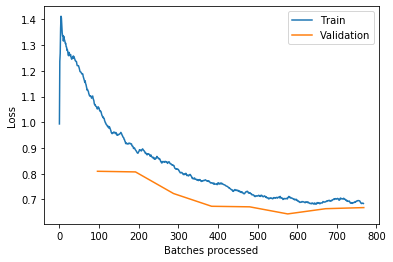

18_224f_lr_0.001_cyc_8_i5_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.132987,0.769939,0.261261,0.738739,00:30
1,0.934557,0.749033,0.202703,0.797297,00:30
2,0.813096,0.729001,0.207207,0.792793,00:31
3,0.777909,0.691131,0.184685,0.815315,00:31
4,0.725866,0.677579,0.166667,0.833333,00:31
5,0.707364,0.723731,0.202703,0.797297,00:31
6,0.700258,0.708426,0.189189,0.810811,00:31
7,0.691523,0.717509,0.189189,0.810811,00:30


Better model found at epoch 0 with accuracy value: 0.7387387156486511.
Better model found at epoch 1 with accuracy value: 0.7972972989082336.
Better model found at epoch 3 with accuracy value: 0.815315306186676.
Better model found at epoch 4 with accuracy value: 0.8333333134651184.


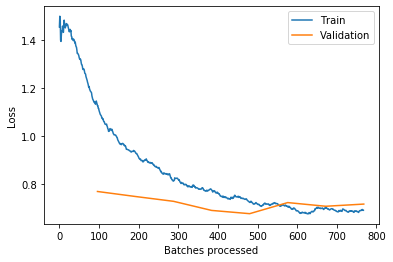

18_224f_lr_0.001_cyc_8_i6_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.062725,0.752212,0.238739,0.761261,00:30
1,0.895155,0.724007,0.229730,0.770270,00:30
2,0.833623,0.684060,0.202703,0.797297,00:31
3,0.779157,0.666958,0.189189,0.810811,00:31
4,0.730437,0.672681,0.207207,0.792793,00:31
5,0.699625,0.646084,0.171171,0.828829,00:30
6,0.701149,0.648309,0.171171,0.828829,00:31
7,0.690594,0.666993,0.166667,0.833333,00:31


Better model found at epoch 0 with accuracy value: 0.7612612843513489.
Better model found at epoch 1 with accuracy value: 0.7702702879905701.
Better model found at epoch 2 with accuracy value: 0.7972972989082336.
Better model found at epoch 3 with accuracy value: 0.8108108043670654.
Better model found at epoch 5 with accuracy value: 0.8288288116455078.
Better model found at epoch 7 with accuracy value: 0.8333333134651184.


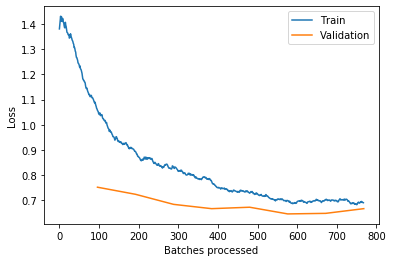

18_224f_lr_0.001_cyc_8_i7_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.098571,0.797290,0.265766,0.734234,00:31
1,0.918726,0.799818,0.234234,0.765766,00:31
2,0.829265,0.762570,0.202703,0.797297,00:31
3,0.779003,0.680817,0.189189,0.810811,00:31
4,0.737158,0.706102,0.171171,0.828829,00:30
5,0.720669,0.662092,0.162162,0.837838,00:30
6,0.703165,0.672724,0.166667,0.833333,00:31
7,0.688817,0.652123,0.162162,0.837838,00:30


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 1 with accuracy value: 0.7657657861709595.
Better model found at epoch 2 with accuracy value: 0.7972972989082336.
Better model found at epoch 3 with accuracy value: 0.8108108043670654.
Better model found at epoch 4 with accuracy value: 0.8288288116455078.
Better model found at epoch 5 with accuracy value: 0.837837815284729.


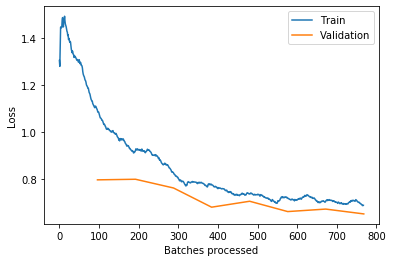

18_224f_lr_0.001_cyc_8_i8_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.143392,0.790075,0.261261,0.738739,00:30
1,0.970043,0.790938,0.229730,0.770270,00:31
2,0.842688,0.732907,0.207207,0.792793,00:31
3,0.794927,0.677551,0.184685,0.815315,00:30
4,0.737777,0.672099,0.162162,0.837838,00:30
5,0.714236,0.663400,0.144144,0.855856,00:31
6,0.694093,0.693325,0.162162,0.837838,00:31
7,0.692769,0.658790,0.139640,0.860360,00:31


Better model found at epoch 0 with accuracy value: 0.7387387156486511.
Better model found at epoch 1 with accuracy value: 0.7702702879905701.
Better model found at epoch 2 with accuracy value: 0.792792797088623.
Better model found at epoch 3 with accuracy value: 0.815315306186676.
Better model found at epoch 4 with accuracy value: 0.837837815284729.
Better model found at epoch 5 with accuracy value: 0.8558558821678162.
Better model found at epoch 7 with accuracy value: 0.8603603839874268.


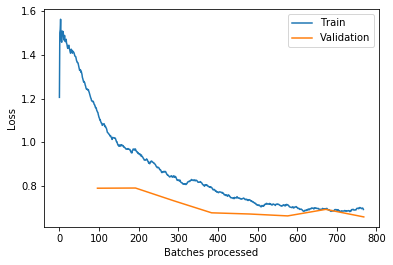

18_224f_lr_0.001_cyc_8_i9_ls_ls


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.098391,0.772413,0.247748,0.752252,00:31
1,0.945138,0.718865,0.207207,0.792793,00:31
2,0.842256,0.704305,0.193694,0.806306,00:31
3,0.763444,0.671940,0.189189,0.810811,00:31
4,0.745002,0.636738,0.144144,0.855856,00:30
5,0.699847,0.643828,0.144144,0.855856,00:30
6,0.700808,0.636293,0.148649,0.851351,00:31
7,0.691725,0.640467,0.144144,0.855856,00:30


Better model found at epoch 0 with accuracy value: 0.7522522807121277.
Better model found at epoch 1 with accuracy value: 0.792792797088623.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 3 with accuracy value: 0.8108108043670654.
Better model found at epoch 4 with accuracy value: 0.8558558821678162.


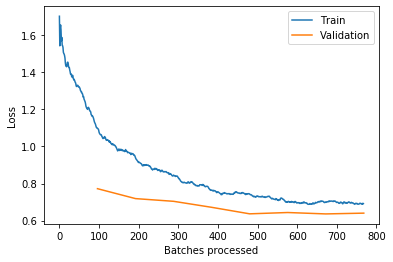

saved stats to: stats\18_224f_stats.p


In [42]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[1e-3]):
        key = f'{key}_i{i}_ls'
        do_train_ls(key, **params)
all_stats.save()

In [43]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.140  med: 0.169   Loss -- best: 0.477  med: 0.664

18_224f_lr_0.003_cyc_4_i0_ls_ls  error_rate: 0.140   accuracy: 0.860   loss:0.6672
18_224f_lr_0.001_cyc_8_i8_ls_ls  error_rate: 0.140   accuracy: 0.860   loss:0.6588
18_224f_lr_0.003_cyc_4_i2_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6858
18_224f_lr_0.003_cyc_4_i9_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6667
18_224f_lr_0.001_cyc_8_i0_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6254
18_224f_lr_0.001_cyc_8_i4_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6439
18_224f_lr_0.001_cyc_8_i9_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6367
18_224f_lr_0.01_cyc_4_i3_ls_m0.2  error_rate: 0.144   accuracy: 0.856   loss:0.6579
18_224f_lr_0.003_cyc_4  error_rate: 0.149   accuracy: 0.851   loss:0.5037
18_224f_lr_0.003_cyc_4_i8_ls_ls  error_rate: 0.149   accuracy: 0.851   loss:0.6769


In [44]:
show_results(all_stats.get(),key='cyc_4', limit=10)

cyc_4           Error -- best: 0.140  med: 0.176   Loss -- best: 0.477  med: 0.665

18_224f_lr_0.003_cyc_4_i0_ls_ls  error_rate: 0.140   accuracy: 0.860   loss:0.6672
18_224f_lr_0.003_cyc_4_i2_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6858
18_224f_lr_0.003_cyc_4_i9_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6667
18_224f_lr_0.01_cyc_4_i3_ls_m0.2  error_rate: 0.144   accuracy: 0.856   loss:0.6579
18_224f_lr_0.003_cyc_4  error_rate: 0.149   accuracy: 0.851   loss:0.5037
18_224f_lr_0.003_cyc_4_i8_ls_ls  error_rate: 0.149   accuracy: 0.851   loss:0.6769
18_224f_lr_0.01_cyc_4_i4_ls  error_rate: 0.149   accuracy: 0.851   loss:0.6270
18_224f_lr_0.003_cyc_4_i6  error_rate: 0.153   accuracy: 0.847   loss:0.5088
18_224f_lr_0.003_cyc_4_i3_ls_ls  error_rate: 0.153   accuracy: 0.847   loss:0.6642
18_224f_lr_0.003_cyc_4_i7  error_rate: 0.158   accuracy: 0.842   loss:0.4768


In [45]:
show_results(all_stats.get(),key='cyc_8', limit=10)

cyc_8           Error -- best: 0.140  med: 0.160   Loss -- best: 0.625  med: 0.660

18_224f_lr_0.001_cyc_8_i8_ls_ls  error_rate: 0.140   accuracy: 0.860   loss:0.6588
18_224f_lr_0.001_cyc_8_i0_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6254
18_224f_lr_0.001_cyc_8_i4_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6439
18_224f_lr_0.001_cyc_8_i9_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6367
18_224f_lr_0.001_cyc_8_i3_ls_ls  error_rate: 0.158   accuracy: 0.842   loss:0.6721
18_224f_lr_0.001_cyc_8_i1_ls_ls  error_rate: 0.162   accuracy: 0.838   loss:0.6574
18_224f_lr_0.001_cyc_8_i2_ls_ls  error_rate: 0.162   accuracy: 0.838   loss:0.7001
18_224f_lr_0.001_cyc_8_i7_ls_ls  error_rate: 0.162   accuracy: 0.838   loss:0.6621
18_224f_lr_0.001_cyc_8_i5_ls_ls  error_rate: 0.167   accuracy: 0.833   loss:0.6776
18_224f_lr_0.001_cyc_8_i6_ls_ls  error_rate: 0.167   accuracy: 0.833   loss:0.6670


In [46]:
show_results(all_stats.get(),key='_ls', limit=10)

_ls             Error -- best: 0.140  med: 0.167   Loss -- best: 0.625  med: 0.677

18_224f_lr_0.003_cyc_4_i0_ls_ls  error_rate: 0.140   accuracy: 0.860   loss:0.6672
18_224f_lr_0.001_cyc_8_i8_ls_ls  error_rate: 0.140   accuracy: 0.860   loss:0.6588
18_224f_lr_0.003_cyc_4_i2_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6858
18_224f_lr_0.003_cyc_4_i9_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6667
18_224f_lr_0.001_cyc_8_i0_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6254
18_224f_lr_0.001_cyc_8_i4_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6439
18_224f_lr_0.001_cyc_8_i9_ls_ls  error_rate: 0.144   accuracy: 0.856   loss:0.6367
18_224f_lr_0.01_cyc_4_i3_ls_m0.2  error_rate: 0.144   accuracy: 0.856   loss:0.6579
18_224f_lr_0.003_cyc_4_i8_ls_ls  error_rate: 0.149   accuracy: 0.851   loss:0.6769
18_224f_lr_0.01_cyc_4_i4_ls  error_rate: 0.149   accuracy: 0.851   loss:0.6270


In [31]:
assert False

AssertionError: 

## Inference

- try composite of 4 learners
- try test-time augmentation

In [ ]:
name = '18_448cut_lr_0.02_cyc_16_i6_m'

In [ ]:
interp = get_interp(name)
print(f'\n{name} tta=False')
analyze_interp(interp)

In [ ]:
interp = get_interp(name, use_tta=True)
print(f'\n{name} tta=True')
analyze_interp(interp)

In [ ]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_results

In [ ]:
top_interp = [[name, get_interp(name)] for name in top_results]

In [ ]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

In [ ]:
len(top_interp[0])

In [ ]:
_ = combine_predictions(top_interp)

### Try again using loss

In [ ]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

In [ ]:
_ = combine_predictions(top_interp)

### Try again using test set

In [ ]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]

In [ ]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

In [ ]:
_ = combine_predictions(top_interp)

In [ ]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]

In [ ]:
_ = combine_predictions(top_interp)

## Experiment with fine tuning classifier

In [ ]:
name = '18_448cut_lr_0.02_cyc_16_i6_m'

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(2e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-4))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-5))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(16, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=2)
stats, new_name

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=8)
stats, new_name

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=8)
    foo.append([1, stats])
foo

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=16)
    foo.append([1, stats])
    print('\n')
foo